In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import scipy as sp
from scipy.signal import convolve2d
from scipy.ndimage import rotate
from skimage.draw import circle


# Custom modules
from lib import myhelpers as hlp
from lib.envmap import Map, Rect

In [9]:
grid_res  = 2 # 2x2 grid resolution
angle_res = 5 # 5 degree angle resolution

robot_dims = np.array([50,50]) # robot is 50 x 50 square
clearance = 50/2    # recontextualizing the robot as a point at the center of the bot,
                    # it requires <clearance> units of clearance between it and an obstacle

# Map dimensions
xlim = (0,800)
ylim = (0,300)

map_width  = np.diff(xlim)
map_height = np.diff(ylim)

# Define map
env = Map(origin=(0,0), xlim=xlim, ylim=ylim, resolution=grid_res, lefthanded=True) # arraylike indiates dimensions are left-handed

obstacles = [
    # Outer borders - start and endpoints
    [(0,0),(800,0)],
    [(0,0),(0,300)],
    [(800,0),(800,300)],
    [(0,300),(800,300)],
    # Inner borders
    [(200,0),(200,200)],
    [(100,200),(300,200)],
    [(400,300),(400,100)],
    [(600,0),(600,200)],
    [(500,200),(700,200)]
]

[env.draw_line(*o) for o in obstacles];



In [ ]:
env.grid

In [ ]:
fig, ax = plt.subplots(figsize=(20,20), facecolor='white')

# Plot environment
scaled_grid = np.kron(env.grid, np.ones((2, 2), dtype=env.grid.dtype)) # Inflate so each grid square is 2x2 pixels
ax.imshow(scaled_grid, cmap='gray_r')
# Plot start and end points with x markers
start = np.array([50,50])
end = np.array([750,50])
plt.scatter(x=[start[0],end[0]], y=[start[1],end[1]], 
            marker='x', c=['g','r'], s=500, linewidth=5)

# Formatting
plt.title('Environment Map', fontsize=36, pad=40)
ax.tick_params(axis='both', labelsize=20)
ax.annotate(xy=start, xytext=[-30,-50], textcoords='offset points',
             text='start', fontsize=26)
ax.annotate(xy=end, xytext=[-25,-50], textcoords='offset points',
             text='goal', fontsize=26);

To determine the free configuration space of the robot at each orientation, we can first find the complement of the freespace by convolving the robot at each orientation with the environmental grid. Any resulting point with a nonzero value represents nonzero overlap between the robot and a wall, and therefore an invalid configuration.

In [10]:
from scipy.ndimage import rotate

# The configuration space will be a 3D array where the first two dimensions are those of
# env_grid, and the third dimension spans the angle space.
# NOTE: A square has rotational symmetry of order 4 -> therefore, we only need to consider 
# rotations (in degrees) mod(theta,360/4), i.e. the rotations [0,90).
orientation = np.arange(0,360//4,angle_res)
cspace = np.zeros((*env.grid.shape,*orientation.shape))

# Create mask of robot to convolve along grid at orientation 0
robot = np.ones(robot_dims//grid_res)


for i,theta in enumerate(orientation):
    # For each orientation, rotate the robot mask and convolve with the unrotated grid. 
    robot_rotated = rotate(robot,angle=theta)
    output = convolve2d(env.grid, robot_rotated, mode='same') # fillvalue=1) # fillvalue=1 to mark points outside the grid as invalid
    
    # Any nonzero square in the output corresponds to a collision/an invalid configuration.
    output[np.nonzero(output)] = 1
    
    # Store each slice in cspace array.
    cspace[...,i] = output
    

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85


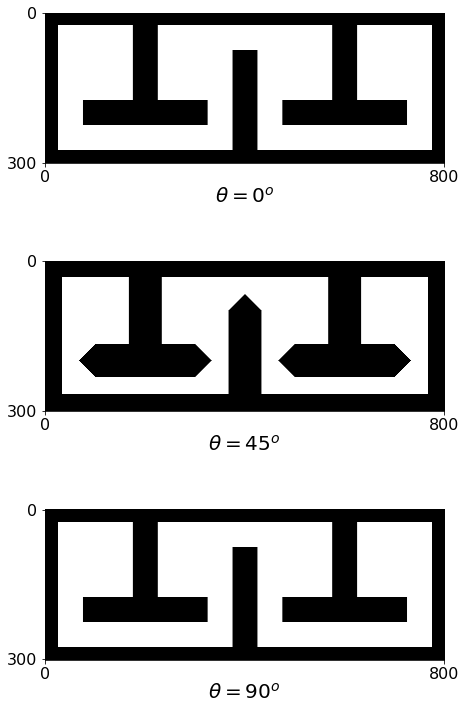

In [102]:


# Plot cspace at theta = 0, 45, 90
theta_test = [0,45,90]

fig, axes = plt.subplots(len(theta_test), figsize=(8,10), facecolor='white')
xticks = np.linspace(0,cspace.shape[1]-1,2).astype(int)
yticks = np.linspace(0,cspace.shape[0]-1,2).astype(int)
xlabels = (xticks*grid_res).astype(str)
ylabels = (yticks*grid_res).astype(str)

for ax,theta in zip(axes,theta_test):
    th = (theta % 90) // angle_res # mod 90 to account for symmetry
    ax.imshow(cspace[...,th], cmap='gray_r')
    
    # Formatting
    ax.set_title(r'$\theta={}^o$'.format(theta), y=-0.3, fontsize=20)
    ax.set_xticks(ticks=xticks)
    ax.set_xticklabels(labels=xlabels, fontsize=16)
    ax.set_yticks(ticks=yticks)
    ax.set_yticklabels(labels=ylabels, fontsize=16)
    

    
fig.tight_layout()
# fig.suptitle(r'$C_{{xy}}$-space at orientation$=\theta$', fontsize=22) #, pad=40)
fig.subplots_adjust(#top=0.85, 
    hspace=0.65)